2500
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving LP
     con: array([], dtype=float64)
     fun: 0.0
 message: 'The solution was determined in presolve as there are no non-trivial constraints.'
     nit: 0
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])


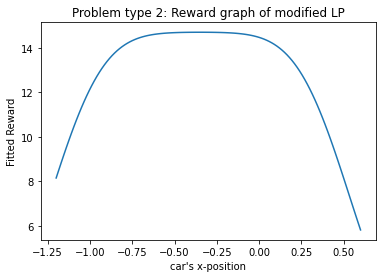

In [6]:
import pickle,random
import numpy as np
import gym
from scipy.optimize import linprog
from math import exp,pi,sqrt
import matplotlib.pyplot as plt

discretization=120
xmin = -1.2
xmax = 0.6
x_binsize=(xmax - xmin)/discretization
#print(xmin,xmax,x_binsize)

vmin = -0.07
vmax = 0.07
v_binsize=(vmax - vmin)/discretization


def calcPDF(a,m,s):
	a=(a-m)/s
	return (exp(-(a)**2/(2))/(sqrt(2*pi)))/s

def getSampleStates():
	sample_states_x=[]
	sample_states_v=[]
	l=[i for i in range(113)]
	for i in range(50):#50
		k=random.choice(l)
		l.remove(k)
		sample_states_x.append(k)
	l=[i for i in range(120)]
	for i in range(50):#50
		k=random.choice(l)
		l.remove(k)
		sample_states_v.append(k)
	sample_states_x.sort()
	sample_states_v.sort()

	S=[]
	for i in sample_states_x:
		for j in sample_states_v:
			S.append([i,j])
	return S


def getState(s):
	xpos = min(discretization-1,round((s[0]-xmin)/x_binsize))
	vpos = min(discretization-1,round((s[1]-vmin)/v_binsize))
	return [int(xpos),int(vpos)]

def getNextState(s,a):
	x=x_binsize*s[0]+xmin
	v=v_binsize*s[1]+vmin
	#print(x,v)
	env.reset()
	obs,R,done,truncated,info=env.step(a)

	return getState(obs)


random.seed(0)
env=gym.make('MountainCar-v0')
#env.seed(1)




f = open('Data\Q_Opt2','rb')
Q=pickle.load(f)
f.close()

#print(Q)
numOfBasis=26
scale=0.5
basis_bin=(0.5+1.2)/(numOfBasis-1)
basis=[-1.2+basis_bin*i for i in range(numOfBasis-1)]+[0.5]
#print(basis)
#value_funcs=[]


# for i in range(0,numOfBasis):
# 	calcValueFunc.getFunction(Q,basis[i],scale,i)
# exit(0)

V=[]
for i in range(numOfBasis):
	f = open('Data\V'+str(i),'rb')
	V.append(pickle.load(f))
	f.close()
#print(len(value_funcs[0][0]))


S0=getSampleStates()
print(len(S0))


c = [0]*(numOfBasis)
bound=[(-1,1) for i in range(numOfBasis)]

for i in range(len(S0)):

	a=np.argmax(np.array(Q[S0[i][0]][S0[i][1]]))
	actions=[0,1,2]
	actions.remove(a)
	r=random.randint(0,1)
	a2=actions[r]

	s=getNextState(S0[i],a)
	s2=getNextState(S0[i],a2)
	
	for j in range(numOfBasis):
		tmpV= -1*V[j][s[0]][s[1]] + V[j][s2[0]][s2[1]]
		if tmpV>0:
			tmpV*=2.4 
		c[j] += tmpV
		
	#print(s,s2,s3)

print(c)
print("Solving LP")
res=linprog(c,bounds=bound)
print(res)

alphas=res['x']
X=[]
R=[]
x=xmin
while x<=xmax:
	X.append(x)
	rx=0
	for k in range(len(basis)):
		rx+=alphas[k]*calcPDF(x,basis[k],0.25) #0.15
	R.append(rx)

	x+=x_binsize


plt.figure(1)
plt.xlabel("car's x-position")
plt.ylabel("Fitted Reward")
plt.title("Problem type 2: Reward graph of modified LP")
plt.plot(X,R)
plt.show()
